In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.neural_network import MLPRegressor

In [48]:
TRAIN_PATIENTS = ['100', '101', '102', '103', '104']
#TRAIN_PATIENTS = ['100', '101', '102']
TEST_PATIENTS = ['106', '119']

SAMPLES_BEFORE = 30
SAMPLES_AFTER = 60
WINDOW_SIZE = SAMPLES_BEFORE + SAMPLES_AFTER

# PCA features - number of qubits
N_DIM = 8
LIMIT_PER_PATIENT = 600

NORMAL_SYMBOLS = ['N', 'L', 'R', 'e', 'j']
ANOMALY_SYMBOLS = ['V', 'A', 'a', 'J', 'S', 'F', '!', 'E', '/']

In [49]:
def load_patient_data(patiend_id):
    # Loads signal and extracts heartbeats based on annotations
    ekg_file = f'archive/{patiend_id}_ekg.csv'
    ann_file = f'archive/{patiend_id}_annotations_1.csv'
    
    if not os.path.exists(ekg_file) or not os.path.exists(ann_file):
        print('File not found')
        return [], []
    
    # Loads patient ECG signal, extracting the MLII column
    df_ekg = pd.read_csv(ekg_file)
    # Strips spaces from column names (common CSV issue)
    df_ekg.columns = df_ekg.columns.str.strip()
    
    try:
        if 'MLII' in df_ekg.columns:
                signal = df_ekg['MLII'].values
        elif 'V5' in df_ekg.columns:
            signal = df_ekg['V5'].values
        else:
            # If names are missing, use index 1 (0 is usually time/sample)
            signal = df_ekg.iloc[:, 1].values
    except Exception as e:
        print(f'Error {e}')
        return [], []
    
    den = np.max(signal) - np.min(signal)
    if den == 0:
        return [], []
    signal = (signal - np.min(signal)) / den
    
    try:
        df_ann = pd.read_csv(ann_file)
        df_ann.columns = df_ann.columns.str.strip() # Clean names
            
        # Locate relevant columns (sample = position, symbol = type)
        # Names may vary ('sample', 'Sample', 'time', etc.)
        sample_col = next((c for c in df_ann.columns if 'index' in c.lower()), None)
        symbol_col = next((c for c in df_ann.columns if 'annotation_symbol' in c.lower()), None)
        
        if not sample_col or not symbol_col:
            print("  Column 'sample' or 'symbol' in annotations not found.")
            return [], []
        
        peaks = df_ann[sample_col].values
        symbols = df_ann[symbol_col].values
    except Exception as e:
        print(f'Error {e}')
        return [], []
    
    beats_normal = []
    beats_anomaly = []
    
    for p, sym in zip(peaks, symbols):
        # Skip heartbeats at the beginning or end of the recording
        if p - SAMPLES_BEFORE < 0 or p + SAMPLES_AFTER > len(signal):
            continue
            
        # Extract segment
        window = signal[p - SAMPLES_BEFORE : p + SAMPLES_AFTER]
        
        # Ensure exact length
        if len(window) != WINDOW_SIZE:
            continue

        # Classification
        if sym in NORMAL_SYMBOLS:
            if len(beats_normal) < LIMIT_PER_PATIENT:
                beats_normal.append(window)
        elif sym in ANOMALY_SYMBOLS:
            if len(beats_anomaly) < LIMIT_PER_PATIENT:
                beats_anomaly.append(window)
                
    print(f"  -> Found: {len(beats_normal)} Normal, {len(beats_anomaly)} Anomaly")
    return beats_normal, beats_anomaly

>>> STEP 1: Loading training data (Healthy)...
  -> Found: 600 Normal, 34 Anomaly
  -> Found: 600 Normal, 3 Anomaly
  -> Found: 99 Normal, 600 Anomaly
  -> Found: 600 Normal, 2 Anomaly
  -> Found: 163 Normal, 600 Anomaly

>>> STEP 2: Loading test data (Mixed)...
  -> Found: 600 Normal, 520 Anomaly
  -> Found: 600 Normal, 444 Anomaly

RAW DATA STATUS:
Single beat dimension: 90 samples
Number of Train samples (Normal): 2062
Number of Test samples (Normal): 1200
Number of Test samples (Anomaly): 964

>>> STEP 3: Dimensionality reduction (PCA) from 90 to 8...
Explained variance (how much info we kept): 99.73%
>>> STEP 4: Scaling to (0, pi) range...
Saved PCA and scaler to file: preprocessing_8dim.joblib

>>> STEP 5: Saving .npy files...
DONE! You can now run the Qiskit script.

>>> Generating control plot...


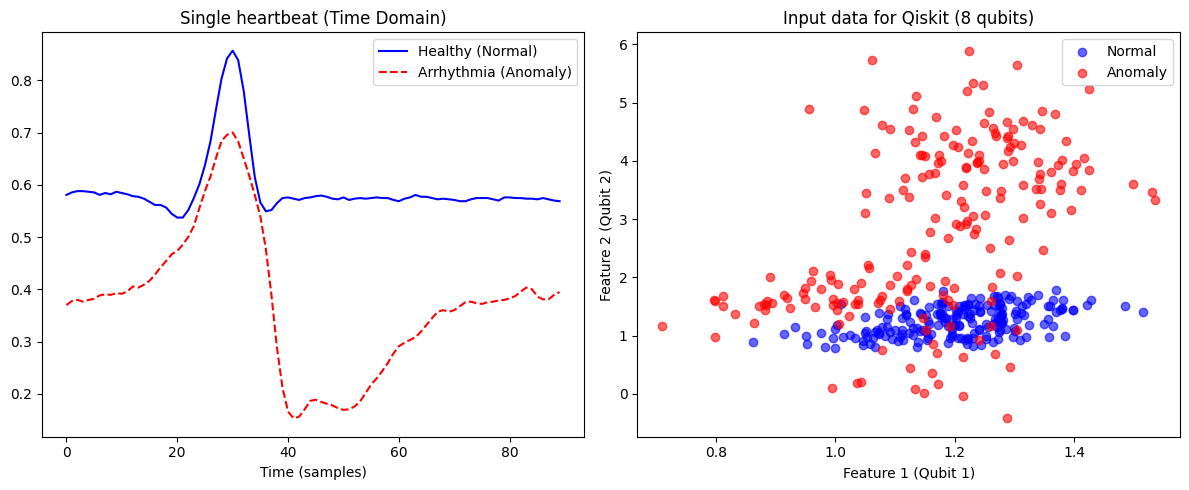

In [50]:
# --- DATA COLLECTION ---
all_train_normal = []
all_test_normal = []
all_test_anomaly = []

print(">>> STEP 1: Loading training data (Healthy)...")
for pid in TRAIN_PATIENTS:
    n, _ = load_patient_data(pid)
    all_train_normal.extend(n)

print("\n>>> STEP 2: Loading test data (Mixed)...")
for pid in TEST_PATIENTS:
    n, a = load_patient_data(pid)
    all_test_normal.extend(n)
    all_test_anomaly.extend(a)

# Convert to numpy array
X_train = np.array(all_train_normal)
X_test_normal = np.array(all_test_normal)
X_test_anomaly = np.array(all_test_anomaly)

print(f"\nRAW DATA STATUS:")
print(f"Single beat dimension: {WINDOW_SIZE} samples")
print(f"Number of Train samples (Normal): {X_train.shape[0]}")
print(f"Number of Test samples (Normal): {X_test_normal.shape[0]}")
print(f"Number of Test samples (Anomaly): {X_test_anomaly.shape[0]}")

if len(X_train) == 0:
    print("CRITICAL ERROR: No training data. Check the CSV filenames!")
    raise ValueError

# --- # PROCESSING (PCA) ---
print(f"\n>>> STEP 3: Dimensionality reduction (PCA) from {WINDOW_SIZE} to {N_DIM}...")

# 1. Fit PCA only on healthy training data
pca = PCA(n_components=N_DIM)
pca.fit(X_train)

# 2. Transform all datasets
X_train_pca = pca.transform(X_train)
X_test_normal_pca = pca.transform(X_test_normal)

# 3. Handle case with no anomalies to prevent crashes
if len(X_test_anomaly) > 0:
    X_test_anomaly_pca = pca.transform(X_test_anomaly)
else:
    X_test_anomaly_pca = np.empty((0, N_DIM))

print(f"Explained variance (how much info we kept): {sum(pca.explained_variance_ratio_):.2%}")

# --- QUANTUM SCALING ---
# Qiskit prefers data in (0, pi) or (-1, 1) range.
# We use (0, pi) for rotation gates.
print(">>> STEP 4: Scaling to (0, pi) range...")

scaler = MinMaxScaler(feature_range=(0, np.pi))
scaler.fit(X_train_pca) # Fit scaler on training data

joblib.dump(
    {
    "pca": pca,
    "scaler": scaler,
    "n_dim": N_DIM,
    "window_size": WINDOW_SIZE
    },
    "ibm_preprocessing_8dim.joblib"
)
print("Saved PCA and scaler to file: preprocessing_8dim.joblib")

X_train_final = scaler.transform(X_train_pca)
X_test_normal_final = scaler.transform(X_test_normal_pca)

if len(X_test_anomaly) > 0:
    X_test_anomaly_final = scaler.transform(X_test_anomaly_pca)
else:
    X_test_anomaly_final = X_test_anomaly_pca

# --- SAVING ---
print("\n>>> STEP 5: Saving .npy files...")
np.save('train_data.npy', X_train_final)
np.save('test_normal.npy', X_test_normal_final)
np.save('test_anomaly.npy', X_test_anomaly_final)
print("DONE! You can now run the Qiskit script.")

# --- VISUALIZATION ---
print("\n>>> Generating control plot...")
plt.figure(figsize=(12, 5))

# Plot 1: Raw heartbeat visualization
plt.subplot(1, 2, 1)
plt.plot(X_train[0], label='Healthy (Normal)', color='blue')
if len(X_test_anomaly) > 0:
    plt.plot(X_test_anomaly[0], label='Arrhythmia (Anomaly)', color='red', linestyle='--')
plt.title("Single heartbeat (Time Domain)")
plt.xlabel("Time (samples)")
plt.legend()

# Plot 2: Post-PCA visualization
plt.subplot(1, 2, 2)
# Plot only 100 points for readability
plt.scatter(X_test_normal_final[:200, 0], X_test_normal_final[:200, 1], 
            c='blue', alpha=0.6, label='Normal')
if len(X_test_anomaly_final) > 0:
    plt.scatter(X_test_anomaly_final[:200, 0], X_test_anomaly_final[:200, 1], 
                c='red', alpha=0.6, label='Anomaly')
plt.title(f"Input data for Qiskit ({N_DIM} qubits)")
plt.xlabel("Feature 1 (Qubit 1)")
plt.ylabel("Feature 2 (Qubit 2)")
plt.legend()

plt.tight_layout()
plt.show()

>>> START: CLASSICAL AUTOENCODER (Input: 8 -> Hidden: 4 -> Output: 8)
    Training on: 600 samples
    Training data: (600, 8)
>>> Neural Network Training...
    Training finished.
    Final Loss: 0.033613


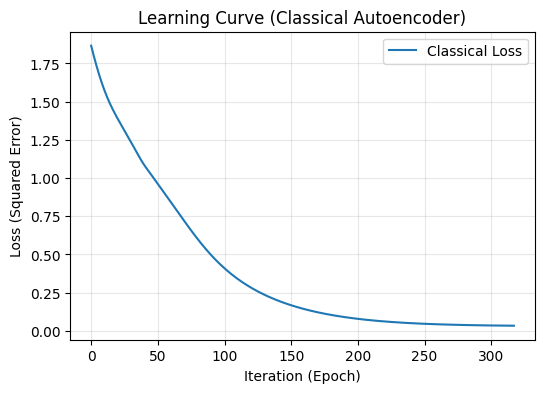

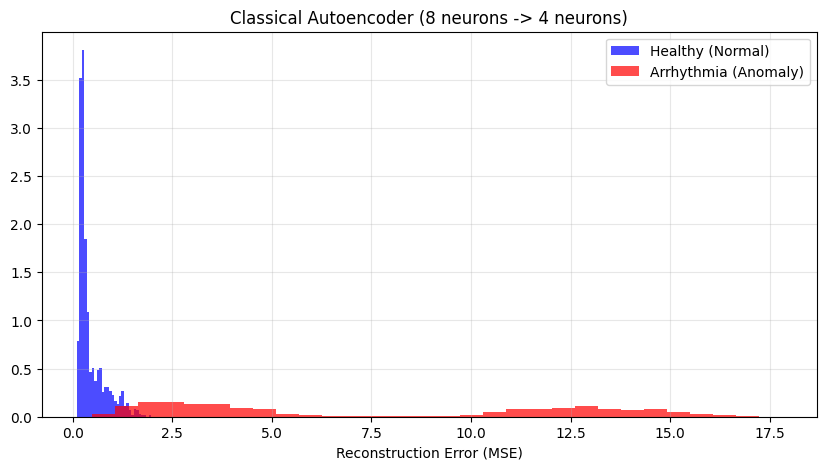


>>> Determined Cut-off Threshold: 4.0017
>>> FINAL RESULTS (CLASSICAL):
    ACCURACY: 81.56%


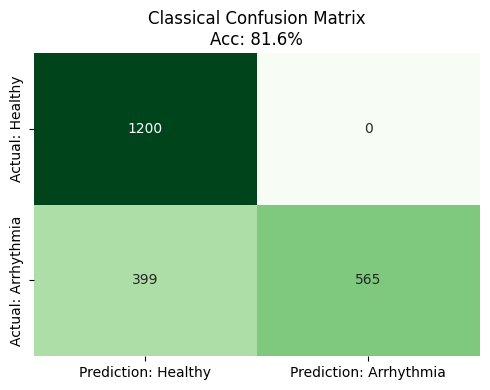

In [51]:
# --- CONFIGURATION (Same as in Quantum) ---
INPUT_DIM = 8       # Equivalent to 8 qubits
HIDDEN_DIM = 4      # Compression equivalent
LIMIT_SAMPLES = 600 # Change to 100, 300, 600 in subsequent tests

print(f">>> START: CLASSICAL AUTOENCODER (Input: {INPUT_DIM} -> Hidden: {HIDDEN_DIM} -> Output: {INPUT_DIM})")

# 1. Loading Data
try:
    train_data = np.load('train_data.npy')[:LIMIT_SAMPLES]
    test_normal = np.load('test_normal.npy')
    test_anomaly = np.load('test_anomaly.npy')
except FileNotFoundError:
    print("ERROR: .npy files missing! Run prepare_data.py")
    exit()

print(f"    Training on: {len(train_data)} samples")
print(f"    Training data: {train_data.shape}")

# 2. Classical Model (MLP)
# Architecture: Input(8) -> Hidden(4) -> Output(8)
# 'tanh' activation is closest to quantum gates (-1 to 1 range)
# 'adam' solver matches the optimizer used in deep networks
autoencoder = MLPRegressor(
    hidden_layer_sizes=(HIDDEN_DIM,), 
    activation='tanh', 
    solver='adam', 
    max_iter=1000, 
    random_state=42
)

# 3. Training (X -> X)
# In an autoencoder, input (X) is also the target (Y). The network must reconstruct the input.
print(">>> Neural Network Training...")
autoencoder.fit(train_data, train_data)
print("    Training finished.")
print(f"    Final Loss: {autoencoder.loss_curve_[-1]:.6f}")

# TRAINING PROCESS VISUALIZATION (LOSS)
plt.figure(figsize=(6, 4))
plt.plot(autoencoder.loss_curve_, label='Classical Loss')
plt.title("Learning Curve (Classical Autoencoder)")
plt.xlabel("Iteration (Epoch)")
plt.ylabel("Loss (Squared Error)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("result_images/classical_loss_gridsearch.png")

# 4. Evaluation (Compute reconstruction error: MSE)
def get_reconstruction_error(data):
    predictions = autoencoder.predict(data)
    # Error is the mean of squared differences between input and output
    mse = np.mean(np.power(data - predictions, 2), axis=1)
    return mse

mse_normal = get_reconstruction_error(test_normal)
mse_anomaly = get_reconstruction_error(test_anomaly)

# 5. Histogram visualization (Compare with IBM plot!)
plt.figure(figsize=(10, 5))
plt.hist(mse_normal, bins=30, alpha=0.7, color='blue', label='Healthy (Normal)', density=True)
plt.hist(mse_anomaly, bins=30, alpha=0.7, color='red', label='Arrhythmia (Anomaly)', density=True)
plt.title(f"Classical Autoencoder (8 neurons -> 4 neurons)")
plt.xlabel("Reconstruction Error (MSE)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("result_images/classical_histogram_gridsearch.png")
plt.show()

# ==========================================
# 6. CALCULATING ACCURACY (Classification)
# ==========================================
# We need to find the threshold that best separates the peaks
# In classical models, arrhythmia USUALLY has a LARGER error (on the right)

# Automatic threshold search (mean between the means of both distributions)
threshold = (np.mean(mse_normal) + np.mean(mse_anomaly)) / 2
print(f"\n>>> Determined Cut-off Threshold: {threshold:.4f}")

# Classification:
# 0 = Healthy (Error < Threshold)
# 1 = Arrhythmia (Error > Threshold)
# NOTE: Here logic is "normal" (large error = disease).
# In quantum you can have "inversion". Here it likely won't be present.

y_pred_norm = [1 if e > threshold else 0 for e in mse_normal]
y_pred_anom = [1 if e > threshold else 0 for e in mse_anomaly]

y_true = [0] * len(mse_normal) + [1] * len(mse_anomaly)
y_pred = y_pred_norm + y_pred_anom

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f">>> FINAL RESULTS (CLASSICAL):")
print(f"    ACCURACY: {acc:.2%}")

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Prediction: Healthy', 'Prediction: Arrhythmia'],
            yticklabels=['Actual: Healthy', 'Actual: Arrhythmia'])
plt.title(f'Classical Confusion Matrix\nAcc: {acc:.1%}')
plt.tight_layout()
plt.savefig("result_images/classical_confusion_matrix_gridsearch.png")
plt.show()

>>> AUC (Area Under Curve): 0.9957


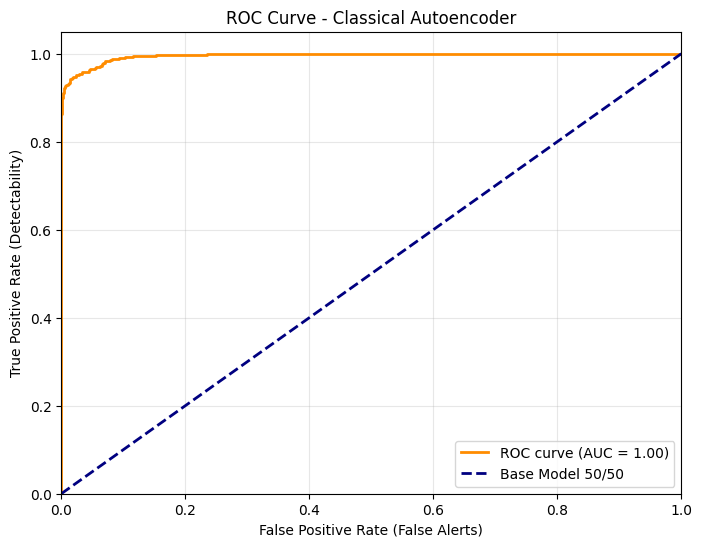

In [52]:
# --- 1. Data Preparation for ROC ---
# Need to combine the results into a single long vector
y_scores = np.concatenate([mse_normal, mse_anomaly])

# We need to create a vector of true labels (0 = Healthy, 1 = Arrhythmia)
y_true = np.concatenate([np.zeros(len(mse_normal)), np.ones(len(mse_anomaly))])

# --- 2. Calculate ROC Curve ---
# The function returns:
# fpr = False Positive Rate (How many times we falsely triggered an alarm)
# tpr = True Positive Rate (How many times we correctly detected the disease)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# --- 3. Calculate AUC (Area Under Curve) ---
# This is the single number you put in the table (e.g., 0.95)
roc_auc = auc(fpr, tpr)
print(f">>> AUC (Area Under Curve): {roc_auc:.4f}")

# --- 4. Drawing the Plot ---
plt.figure(figsize=(8, 6))

# Draw the model curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Draw the random guess line (diagonal)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Base Model 50/50')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (False Alerts)')
plt.ylabel('True Positive Rate (Detectability)')
plt.title('ROC Curve - Classical Autoencoder')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.savefig("result_images/classical_roc_curve_gridsearch.png")
plt.show()

In [53]:
# --- CONFIGURATION ---
ALL_AVAILABLE_PATIENTS = ['100', '101', '102', '103', '104']
# Which patient configurations are we testing?
# 1 = ['100']
# 2 = ['100', '101']
# 3 = ['100', '101', '102']
# 5 = ['100', '101', '102', '103', '104']
PATIENT_COUNTS_TO_TEST = [1, 2, 3, 5]

LIMITS_PER_PATIENT = [200, 600]  # Limits to test data volume impact
HIDDEN_DIMS = [4, 2]             # Investigation of hidden layer size
MAX_CHUNK_SIZE = 600

print(f">>> 1. Loading data (requiring {len(ALL_AVAILABLE_PATIENTS)} patients in file)...")
try:
    full_train_data = np.load('train_data.npy')
    test_normal = np.load('test_normal.npy')
    test_anomaly = np.load('test_anomaly.npy')
except FileNotFoundError:
    print("ERROR: Data files missing! Run prepare_data.py with 5 patients.")
    exit()

# Check if the file is large enough
expected_min_size = len(ALL_AVAILABLE_PATIENTS) * MAX_CHUNK_SIZE
if len(full_train_data) < expected_min_size:
    print(f"WARNING: The train_data.npy file contains {len(full_train_data)} samples.")
    print(f"We need {expected_min_size} (5 patients * 600).")
    print("Are you sure you ran prepare_data with the list ['100'...'104']?")

results_table = []

print("\n>>> 2. Starting Grid Search (This might take a while)...")

for h_dim in HIDDEN_DIMS:
    for n_patients in PATIENT_COUNTS_TO_TEST:
        
        # Generate patient group name (e.g., "['100', '101']")
        current_patients_ids = ALL_AVAILABLE_PATIENTS[:n_patients]
        
        for limit in LIMITS_PER_PATIENT:
            
            # --- DATA PREPARATION (Slicing) ---
            batch_parts = []
            
            # Loop over specific patients in this configuration
            for i in range(n_patients):
                # Calculate where a given patient starts and ends in the large file
                # Patient 0: 0-600, Patient 1: 600-1200, etc.
                start_in_file = i * MAX_CHUNK_SIZE
                end_in_file = start_in_file + limit # We only take 'limit' samples
                
                # Safeguard
                if start_in_file >= len(full_train_data):
                    break
                    
                chunk = full_train_data[start_in_file : end_in_file]
                batch_parts.append(chunk)
            
            if not batch_parts:
                continue
                
            current_train_data = np.concatenate(batch_parts)
            total_samples = len(current_train_data)
            
            # Log progress
            print(f" -> H={h_dim} | Patients={n_patients} {current_patients_ids} | Limit={limit} (Sum: {total_samples})")

            # --- TRAINING ---
            model = MLPRegressor(
                hidden_layer_sizes=(h_dim,),
                activation='tanh',
                solver='adam',
                max_iter=1000,
                random_state=42 # Fixed seed for reproducibility
            )
            
            model.fit(current_train_data, current_train_data)
            
            # --- RESULTS ---
            final_loss = model.loss_curve_[-1]
            
            # MSE
            pred_norm = model.predict(test_normal)
            mse_norm = np.mean(np.power(test_normal - pred_norm, 2), axis=1)
            
            pred_anom = model.predict(test_anomaly)
            mse_anom = np.mean(np.power(test_anomaly - pred_anom, 2), axis=1)
            
            # ROC AUC
            y_scores = np.concatenate([mse_norm, mse_anom])
            y_true = [0] * len(mse_norm) + [1] * len(mse_anom)
            
            try:
                auc_score = roc_auc_score(y_true, y_scores)
            except ValueError:
                auc_score = 0.5
            
            # Accuracy (automatic threshold)
            threshold = (np.mean(mse_norm) + np.mean(mse_anom)) / 2
            y_pred = [1 if x > threshold else 0 for x in y_scores]
            acc_score = accuracy_score(y_true, y_pred)
            
            # Save record
            results_table.append({
                "Hidden Dim": h_dim,
                "Patient Count": n_patients,
                "Patient IDs": str(current_patients_ids),
                "Limit/Patient": limit,
                "Total Samples": total_samples,
                "Loss": round(final_loss, 6),
                "Accuracy (%)": round(acc_score * 100, 2),
                "ROC AUC": round(auc_score, 4)
            })

# --- SAVE ---
df = pd.DataFrame(results_table)
# Sorting: First Architecture, then number of patients, then limit
df = df.sort_values(by=["Hidden Dim", "Patient Count", "Limit/Patient"])

print("\n" + "="*100)
print("FINAL RESULTS - EFFECTS OF SCALE AND ARCHITECTURE")
print("="*100)
print(df.to_string(index=False))

filename = "experiment_results_5_patients.csv"
df.to_csv(filename, index=False)
print(f"\n>>> Saved to file: {filename}")

>>> 1. Loading data (requiring 5 patients in file)...
We need 3000 (5 patients * 600).
Are you sure you ran prepare_data with the list ['100'...'104']?

>>> 2. Starting Grid Search (This might take a while)...
 -> H=4 | Patients=1 ['100'] | Limit=200 (Sum: 200)
 -> H=4 | Patients=1 ['100'] | Limit=600 (Sum: 600)
 -> H=4 | Patients=2 ['100', '101'] | Limit=200 (Sum: 400)
 -> H=4 | Patients=2 ['100', '101'] | Limit=600 (Sum: 1200)
 -> H=4 | Patients=3 ['100', '101', '102'] | Limit=200 (Sum: 600)
 -> H=4 | Patients=3 ['100', '101', '102'] | Limit=600 (Sum: 1800)
 -> H=4 | Patients=5 ['100', '101', '102', '103', '104'] | Limit=200 (Sum: 800)
 -> H=4 | Patients=5 ['100', '101', '102', '103', '104'] | Limit=600 (Sum: 2062)
 -> H=2 | Patients=1 ['100'] | Limit=200 (Sum: 200)


c:\Users\Marcepano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


 -> H=2 | Patients=1 ['100'] | Limit=600 (Sum: 600)
 -> H=2 | Patients=2 ['100', '101'] | Limit=200 (Sum: 400)
 -> H=2 | Patients=2 ['100', '101'] | Limit=600 (Sum: 1200)
 -> H=2 | Patients=3 ['100', '101', '102'] | Limit=200 (Sum: 600)
 -> H=2 | Patients=3 ['100', '101', '102'] | Limit=600 (Sum: 1800)
 -> H=2 | Patients=5 ['100', '101', '102', '103', '104'] | Limit=200 (Sum: 800)
 -> H=2 | Patients=5 ['100', '101', '102', '103', '104'] | Limit=600 (Sum: 2062)

FINAL RESULTS - EFFECTS OF SCALE AND ARCHITECTURE
 Hidden Dim  Patient Count                         Patient IDs  Limit/Patient  Total Samples     Loss  Accuracy (%)  ROC AUC
          2              1                             ['100']            200            200 0.079779         80.82   0.9887
          2              1                             ['100']            600            600 0.038507         81.05   0.9912
          2              2                      ['100', '101']            200            400 0.054716        

In [54]:
wyniki_tabelka = pd.read_csv('experiment_results_5_patients.csv')
wyniki_tabelka.columns = ['Hidden Layer Neurons', 'Number of Patients', 'Patient ID', 'Sample Limit / Patient', 'Summed samples', 'Loss', 'Accuracy (%)', 'ROC AUC']
wyniki_tabelka.drop('Patient ID', axis=1, inplace=True)
wyniki_tabelka.head(32)

,Hidden Layer Neurons,Number of Patients,Sample Limit / Patient,Summed samples,Loss,Accuracy (%),ROC AUC
0,2,1,200,200,0.079779,80.82,0.9887
1,2,1,600,600,0.038507,81.05,0.9912
2,2,2,200,400,0.054716,80.31,0.9889
3,2,2,600,1200,0.052823,80.45,0.9920
4,2,3,200,600,0.091564,81.05,0.9885
5,2,3,600,1800,0.069110,80.91,0.9932
6,2,5,200,800,0.096991,80.91,0.9882
7,2,5,600,2062,0.076644,80.91,0.9925
8,4,1,200,200,0.038846,81.24,0.9946
9,4,1,600,600,0.033613,81.56,0.9957


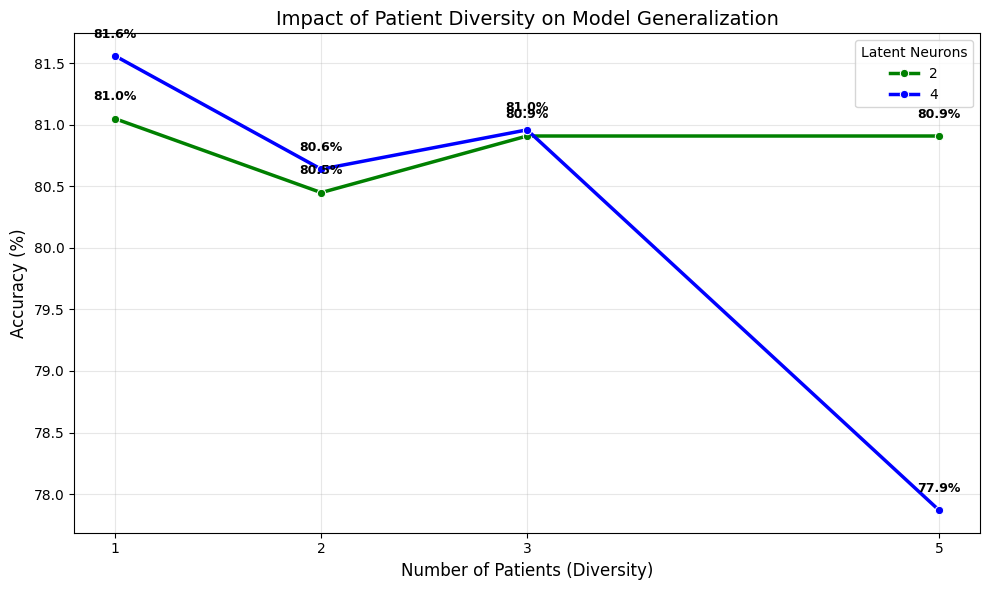

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data - we are interested in "full training" (600 samples), as it shows the real performance
plot_data = wyniki_tabelka[wyniki_tabelka['Sample Limit / Patient'] == 600]

plt.figure(figsize=(10, 6))

# Draw a line plot with markers
sns.lineplot(
    data=plot_data,
    x='Number of Patients',
    y='Accuracy (%)',
    hue='Hidden Layer Neurons',
    palette=['green', 'blue'],
    marker='o',
    linewidth=2.5
)

plt.title('Impact of Patient Diversity on Model Generalization', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xlabel('Number of Patients (Diversity)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks([1, 2, 3, 5]) # Force showing only these specific numbers on the X axis
plt.legend(title='Latent Neurons')

# Add value labels next to the points 
for x, y, val in zip(plot_data['Number of Patients'], plot_data['Accuracy (%)'], plot_data['Accuracy (%)']):
    plt.text(x, y+0.15, f'{val:.1f}%', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('result_images/scalability_chart_gridsearch.png')
plt.show()